<a href="https://colab.research.google.com/github/Shelenadah/Data-science/blob/main/Survival_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **In this notebook, Breast Cancer (METABRIC) dataset is used for the analysis. It consists of clinical profiles of 2,509 breast cancer patients, time period between diagnosis and death, and time period between diagnosis and relapse.**

In [2]:
!pip install lifelines


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 11.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=c579aef58bc2909e45eaf569e49af36b0c42dce9cfd063e60bdbd102597d5abd
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index

import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gunesevitan/breast-cancer-metabric")

print("Path to dataset files:", path)

100%|██████████| 77.2k/77.2k [00:00<00:00, 48.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/gunesevitan/breast-cancer-metabric/versions/1


In [17]:
import pandas as pd

df = pd.read_csv(path + '/Breast Cancer METABRIC.csv')  # or whatever the exact filename is
print(df.head())

  Patient ID  Age at Diagnosis Type of Breast Surgery    Cancer Type                       Cancer Type Detailed Cellularity Chemotherapy Pam50 + Claudin-low subtype  Cohort ER status measured by IHC ER Status  Neoplasm Histologic Grade HER2 status measured by SNP6 HER2 Status Tumor Other Histologic Subtype Hormone Therapy Inferred Menopausal State Integrative Cluster Primary Tumor Laterality  Lymph nodes examined positive  Mutation Count  Nottingham prognostic index Oncotree Code  Overall Survival (Months) Overall Survival Status PR Status Radio Therapy  Relapse Free Status (Months) Relapse Free Status     Sex 3-Gene classifier subtype  Tumor Size  Tumor Stage Patient's Vital Status
0    MB-0000             75.65             Mastectomy  Breast Cancer           Breast Invasive Ductal Carcinoma         NaN           No                 claudin-low     1.0                   Positve  Positive                        3.0                      Neutral    Negative                     Ductal/NST 

In [20]:
df.shape

(2509, 34)

## **Exploratory Data Analysis**

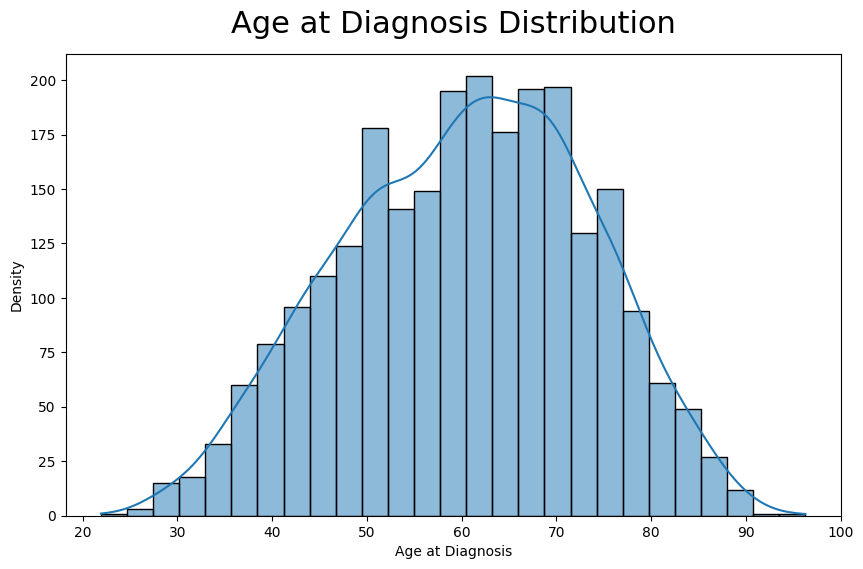

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Age at Diagnosis'], kde=True)  # use histplot instead of distplot (distplot is deprecated)
plt.title('Age at Diagnosis Distribution', fontsize=22, pad=15)
plt.xlabel('Age at Diagnosis')
plt.ylabel('Density')
plt.show()

In [58]:
mean_value = df['Age at Diagnosis'].mean()
print("Mean:", mean_value)

Mean: 60.420300240192155


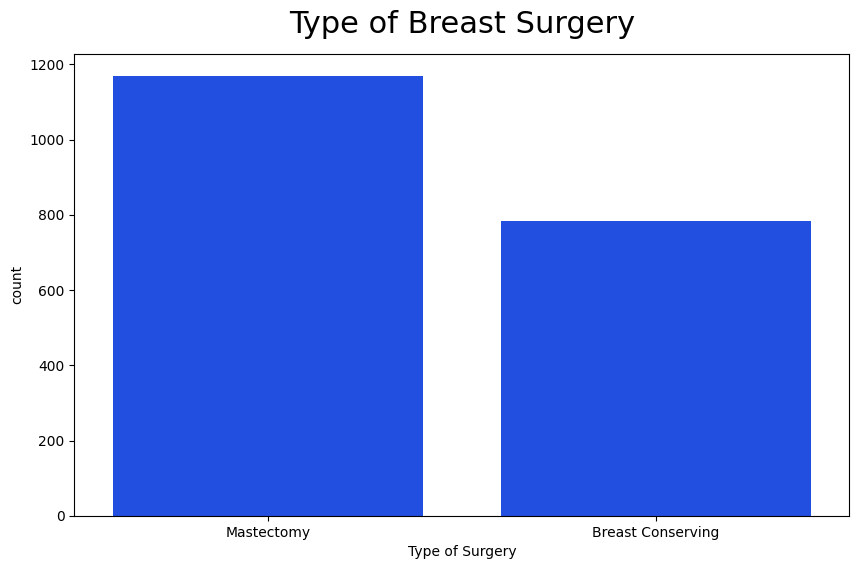

In [43]:
plt.figure(figsize=(10, 6))

sns.countplot(data=df, x='Type of Breast Surgery')  # <-- note: 'y' for horizontal bars

plt.title('Type of Breast Surgery', fontsize=22, pad=15)
plt.ylabel('count')
plt.xlabel('Type of Surgery')
plt.show()

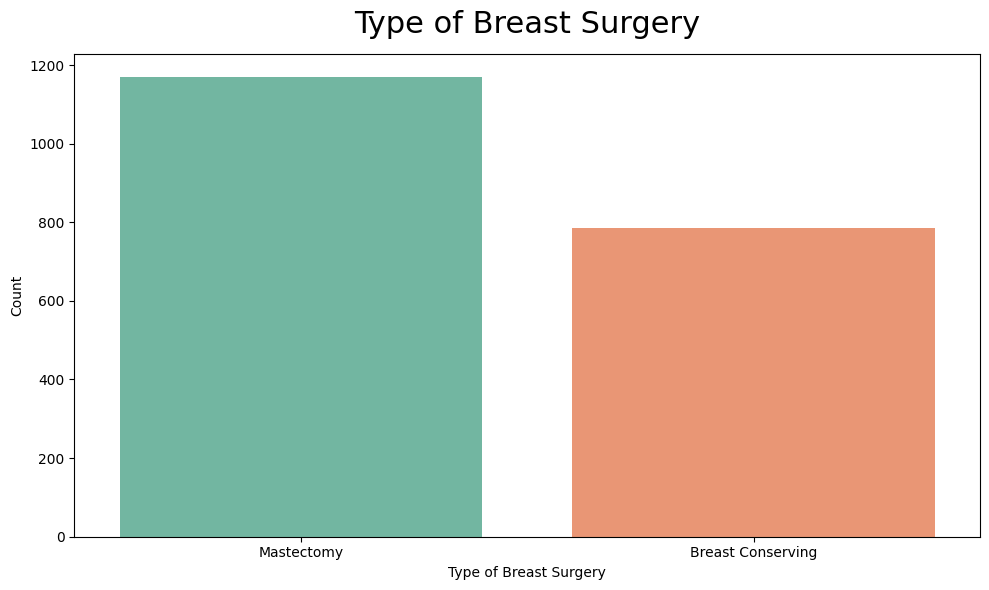

In [47]:
# Create figure
plt.figure(figsize=(10, 6))

# Get a nice palette with as many colors as needed
unique_surgeries = df['Type of Breast Surgery'].value_counts().index
palette = sns.color_palette('Set2', len(unique_surgeries))  # Or 'pastel', 'tab10', etc.

# Create countplot with custom palette
sns.countplot(data=df, x='Type of Breast Surgery', palette=palette)

# Titles and labels
plt.title('Type of Breast Surgery', fontsize=22, pad=15)
plt.xlabel('Type of Breast Surgery')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

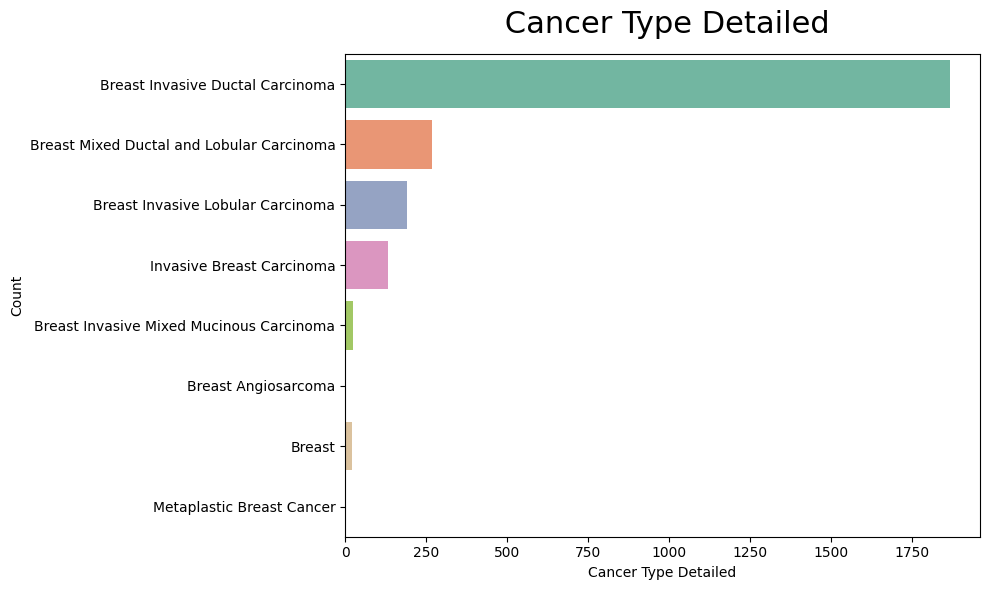

In [55]:
# Create figure
plt.figure(figsize=(10, 6))

# Get a nice palette with as many colors as needed
unique_surgeries = df['Cancer Type Detailed'].value_counts().index
palette = sns.color_palette('Set2', len(unique_surgeries))  # Or 'pastel', 'tab10', etc.

# Create countplot with custom palette
sns.countplot(data=df, y='Cancer Type Detailed', palette=palette)

# Titles and labels
plt.title(' Cancer Type Detailed', fontsize=22, pad=15)
plt.xlabel('Cancer Type Detailed')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

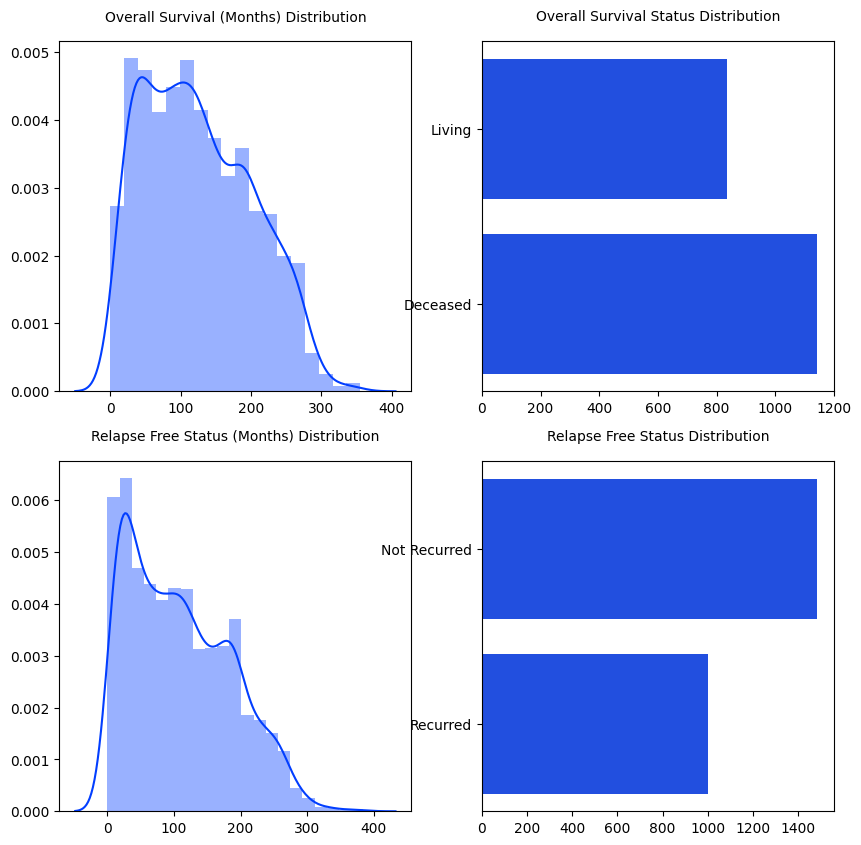

In [62]:
ig, axes = plt.subplots(figsize=(10, 10), ncols=2, nrows=2)

sns.distplot(df['Overall Survival (Months)'], ax=axes[0][0])
sns.countplot(df['Overall Survival Status'], ax=axes[0][1])
sns.distplot(df['Relapse Free Status (Months)'], ax=axes[1][0])
sns.countplot(df['Relapse Free Status'], ax=axes[1][1])

for i in range(2):
    for j in range(2):
        if i == 1 and j == 1:
            axes[i][j].tick_params(axis='x', labelsize=10)
        else:
            axes[i][j].tick_params(axis='x', labelsize=10)
        axes[i][j].tick_params(axis='y', labelsize=10)

        axes[i][j].set_xlabel('')
        axes[i][j].set_ylabel('')

axes[0][0].set_title('Overall Survival (Months) Distribution', size=10, pad=15)
axes[0][1].set_title('Overall Survival Status Distribution', size=10, pad=15)
axes[1][0].set_title('Relapse Free Status (Months) Distribution', size=10, pad=15)
axes[1][1].set_title('Relapse Free Status Distribution', size=10, pad=15)

plt.show()

There are two events listed in the dataset. Those events are survival (Overall Survival Status) and relapse (Relapse Free Status). There are also two durations associated with those events which are Overall Survival (Months) and Relapse Free Status (Months). Survival analysis is based on those two events and their durations. Both of the durations follow very similar distributions, but distribution of events are slightly different. For survival event, "Deceased" label is more common that corresponds to event happened, but in relapse event "Not Recurred" label is more common and that corresponds to event didn't happen

<Axes: xlabel='Overall Survival Status', ylabel='Age at Diagnosis'>

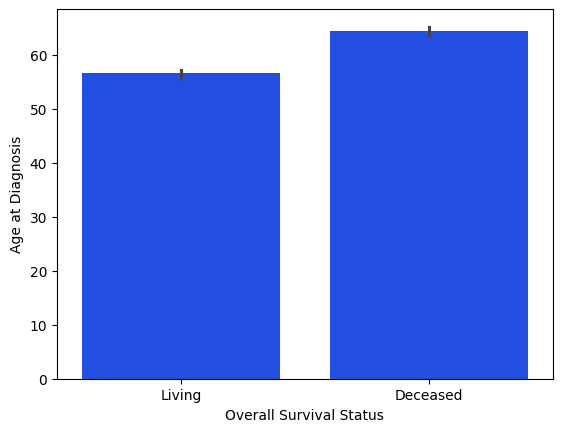

In [73]:
sns.barplot(y='Age at Diagnosis', x='Overall Survival Status', data=df)


# **Data Preprocessing**

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Patient ID                      2509 non-null   object 
 1   Age at Diagnosis                2498 non-null   float64
 2   Type of Breast Surgery          1955 non-null   object 
 3   Cancer Type                     2509 non-null   object 
 4   Cancer Type Detailed            2509 non-null   object 
 5   Cellularity                     1917 non-null   object 
 6   Chemotherapy                    1980 non-null   object 
 7   Pam50 + Claudin-low subtype     1980 non-null   object 
 8   Cohort                          2498 non-null   float64
 9   ER status measured by IHC       2426 non-null   object 
 10  ER Status                       2469 non-null   object 
 11  Neoplasm Histologic Grade       2388 non-null   float64
 12  HER2 status measured by SNP6    19

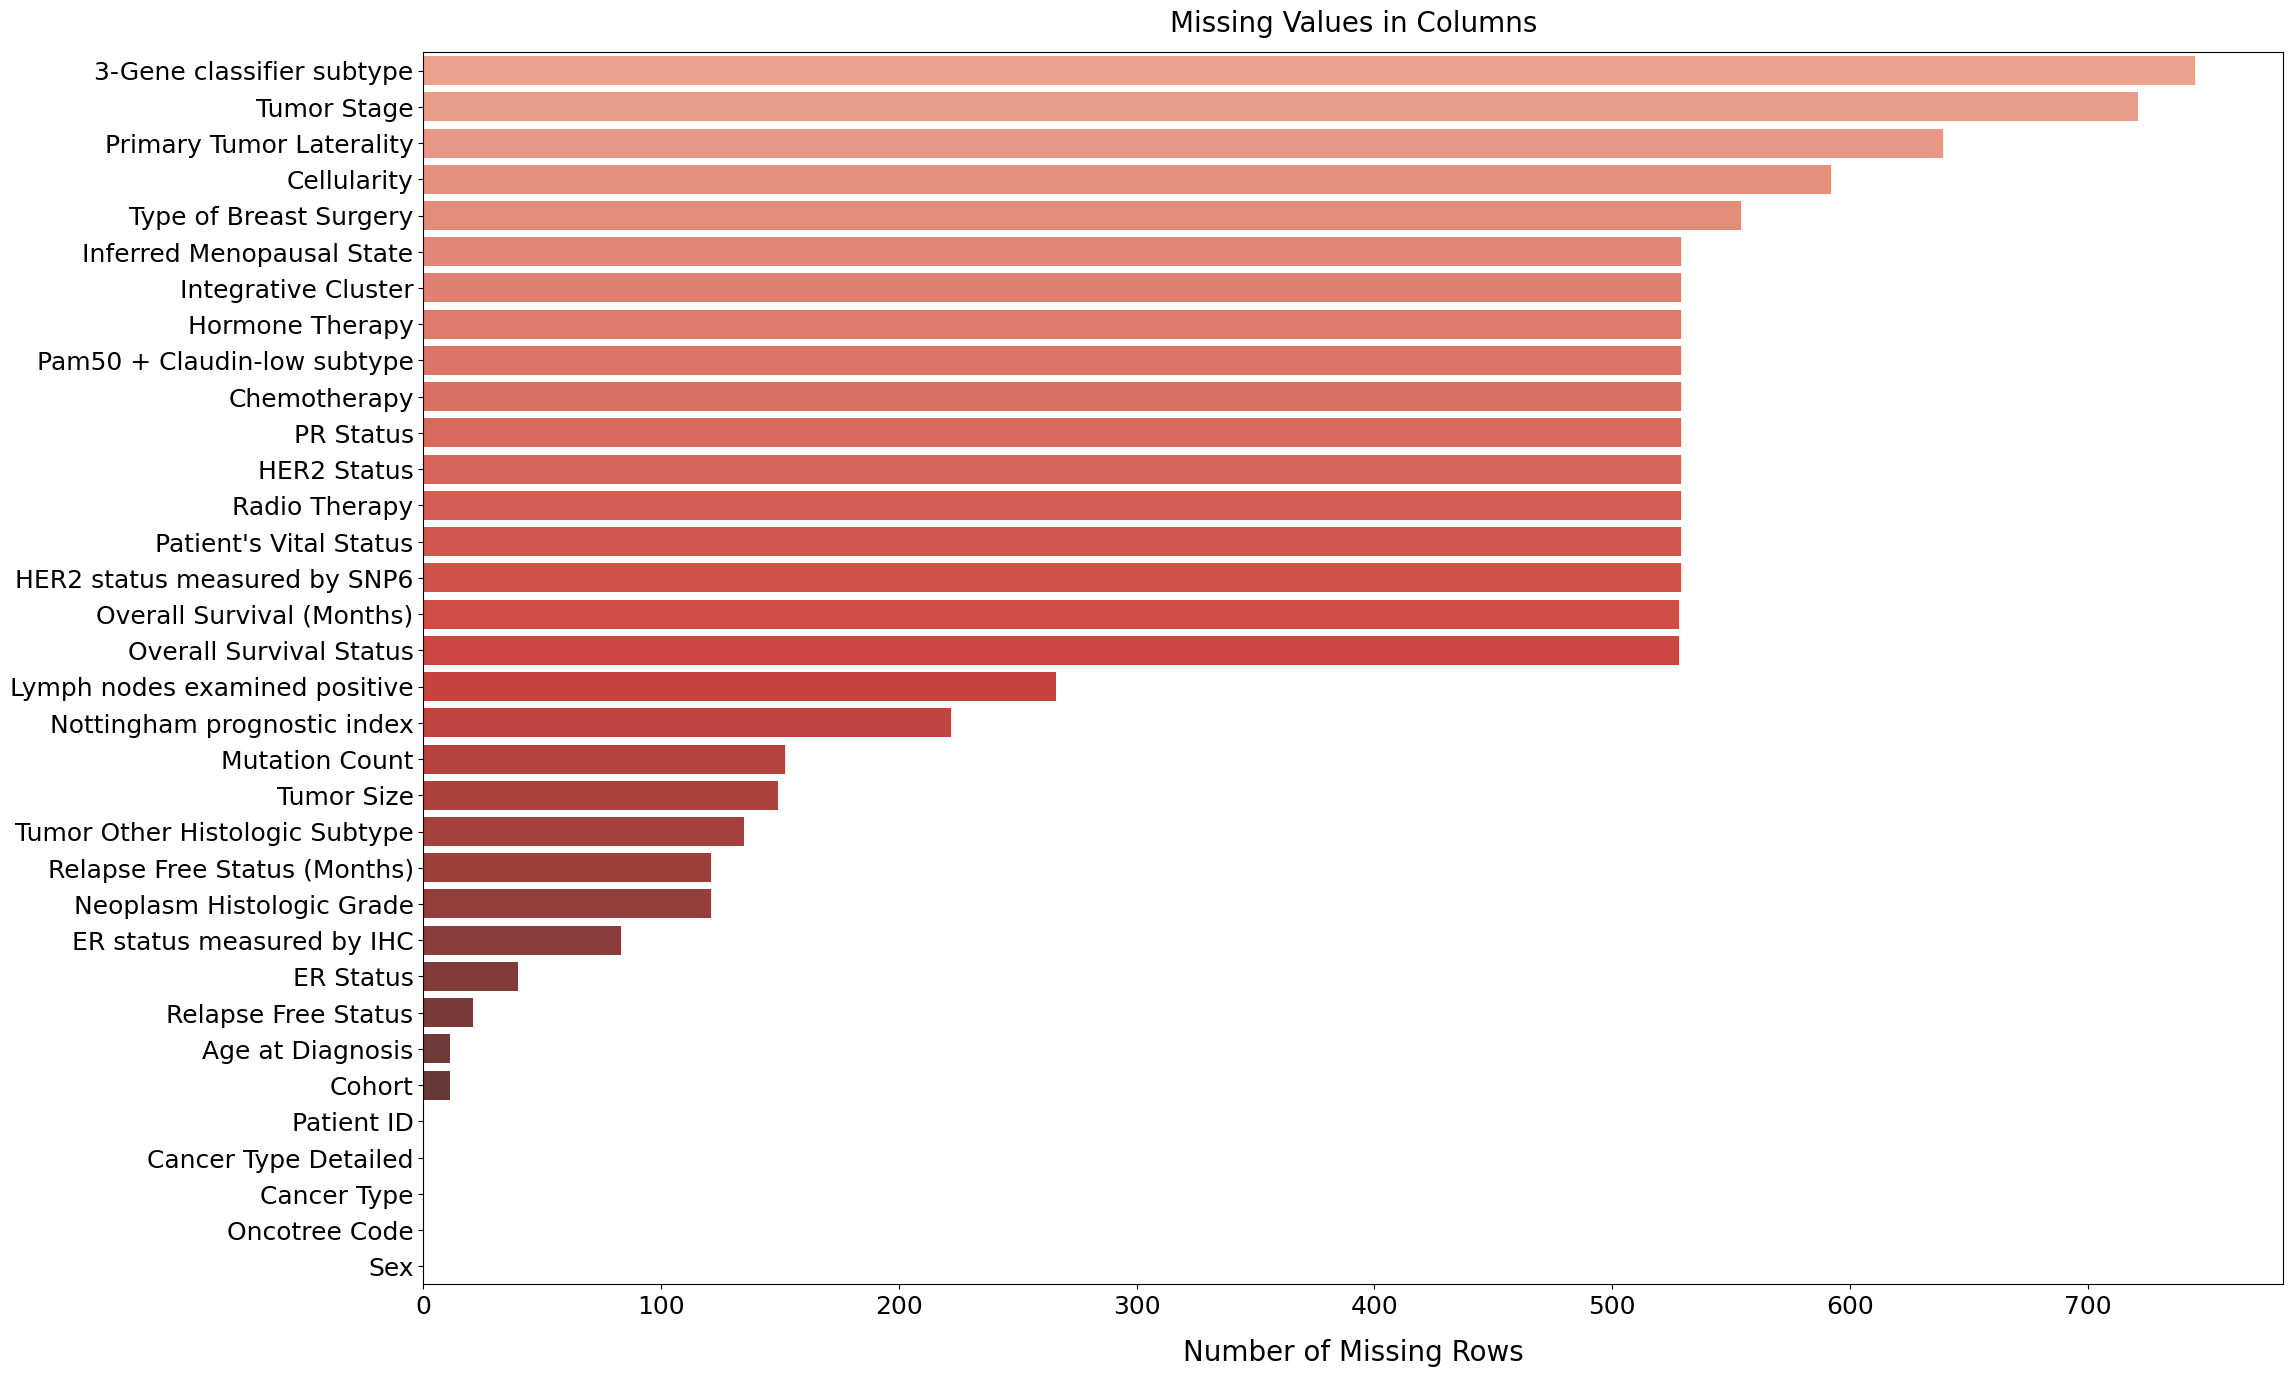

In [75]:
fig = plt.figure(figsize=(24, 16))

sns.barplot(x=df.isnull().sum().sort_values(ascending=False).values,
            y=df.isnull().sum().sort_values(ascending=False).index,
            palette='Reds_d')

plt.xlabel('Number of Missing Rows', size=20, labelpad=15)
plt.ylabel('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('Missing Values in Columns', size=20, pad=15)

plt.show()

here are 29 columns with missing values and only 5 columns don't have missing values in them. Those columns are Sex, Cancer Type Detailed, Cancer Type, Oncotree Code, and Patient ID. Cancer Type and Cancer Type Detailed can be very useful for imputation, but others don't yield any information.

# **Data Cleaning**

In [83]:
def get_mode(x):
    mode_val = x.mode()
    if not mode_val.empty:
        return mode_val.iloc[0]
    else:
        return np.nan  # or pick a default value if you want

# Then apply it like this:
df['Neoplasm Histologic Grade'] = df.groupby(['Cancer Type Detailed'])['Neoplasm Histologic Grade'].transform(lambda x: x.fillna(get_mode(x)))
df['Neoplasm Histologic Grade'] = df['Neoplasm Histologic Grade'].fillna(df['Neoplasm Histologic Grade'].mode().iloc[0])


In [85]:
# Event and duration columns
df['Relapse Free Status'] = df.groupby(['Cancer Type Detailed'])['Relapse Free Status'].transform(lambda x: x.fillna(x.mode().iloc[0]))
df['Relapse Free Status (Months)'] = df.groupby(['Cancer Type Detailed', 'Relapse Free Status'])['Relapse Free Status (Months)'].transform(lambda x: x.fillna(x.mean()))
df['Overall Survival Status'] = df.groupby(['Cancer Type Detailed', 'Relapse Free Status'])['Overall Survival Status'].transform(lambda x: x.fillna(x.mode().iloc[0]))
df['Overall Survival (Months)'] = df.groupby(['Cancer Type Detailed', 'Overall Survival Status'])['Overall Survival (Months)'].transform(lambda x: x.fillna(x.mean()))

# ER, PR, HER2 status columns
df['ER status measured by IHC'] = df['ER status measured by IHC'].fillna(df['ER status measured by IHC'].mode().iloc[0])
df['ER Status'] = df.groupby(['ER status measured by IHC'])['ER Status'].transform(lambda x: x.fillna(x.mode().iloc[0]))
df['HER2 status measured by SNP6'] = df['HER2 status measured by SNP6'].fillna(df['HER2 status measured by SNP6'].mode().iloc[0])
df['HER2 Status'] = df.groupby(['HER2 status measured by SNP6'])['HER2 Status'].transform(lambda x: x.fillna(x.mode().iloc[0]))
df['PR Status'] = df.groupby(['Cancer Type Detailed'])['PR Status'].transform(lambda x: x.fillna(x.mode().iloc[0]))

# Chemotherapy, Hormone Therapy, Radio Therapy columns
df['Chemotherapy'] = df.groupby(['Cancer Type Detailed'])['Chemotherapy'].transform(lambda x: x.fillna(x.mode().iloc[0]))
df['Hormone Therapy'] = df.groupby(['Cancer Type Detailed'])['Hormone Therapy'].transform(lambda x: x.fillna(x.mode().iloc[0]))
df['Radio Therapy'] = df.groupby(['Cancer Type Detailed'])['Radio Therapy'].transform(lambda x: x.fillna(x.mode().iloc[0]))

# Other columns
df['Age at Diagnosis'] = df.groupby(['Cancer Type Detailed'])['Age at Diagnosis'].transform(lambda x: x.fillna(x.mean()))
df['Cohort'] = df.groupby(['Cancer Type Detailed'])['Cohort'].transform(lambda x: x.fillna(x.median()))
df['Cellularity'] = df.groupby(['Cancer Type Detailed'])['Cellularity'].transform(lambda x: x.fillna(x.mode().iloc[0]))
df['Tumor Stage'] = df.groupby(['Cancer Type Detailed', 'Cellularity'])['Tumor Stage'].transform(lambda x: x.fillna(x.median()))
df['Tumor Stage'] = df.groupby(['Cancer Type Detailed'])['Tumor Stage'].transform(lambda x: x.fillna(x.median()))
df['Tumor Size'] = df.groupby(['Cancer Type Detailed', 'Tumor Stage'])['Tumor Size'].transform(lambda x: x.fillna(x.median()))
df['Tumor Size'] = df.groupby(['Cancer Type Detailed'])['Tumor Size'].transform(lambda x: x.fillna(x.median()))
df['Tumor Size'] = df['Tumor Size'].fillna(df['Tumor Size'].mode().iloc[0])
df['Neoplasm Histologic Grade'] = df.groupby(['Cancer Type Detailed'])['Neoplasm Histologic Grade'].transform(lambda x: x.fillna(x.mode().iloc[0]))
df['Neoplasm Histologic Grade'] = df['Neoplasm Histologic Grade'].fillna(df['Neoplasm Histologic Grade'].mode().iloc[0])
df['Primary Tumor Laterality'] = df.groupby(['Cancer Type Detailed'])['Primary Tumor Laterality'].transform(lambda x: x.fillna(x.mode().iloc[0]))

# Drop unnecessary column
df.drop(columns=["Patient's Vital Status"], inplace=True)


In [88]:
import numpy as np

# Helper functions
def get_mode(x):
    mode_val = x.mode()
    if not mode_val.empty:
        return mode_val.iloc[0]
    else:
        return np.nan

def get_median(x):
    return x.median()

def get_mean(x):
    return x.mean()

# --- Start fixing and filling ---

# Event and duration columns
df['Relapse Free Status'] = df.groupby('Cancer Type Detailed')['Relapse Free Status'].transform(lambda x: x.fillna(get_mode(x)))
df['Relapse Free Status (Months)'] = df.groupby(['Cancer Type Detailed', 'Relapse Free Status'])['Relapse Free Status (Months)'].transform(lambda x: x.fillna(get_mean(x)))
df['Overall Survival Status'] = df.groupby(['Cancer Type Detailed', 'Relapse Free Status'])['Overall Survival Status'].transform(lambda x: x.fillna(get_mode(x)))
df['Overall Survival (Months)'] = df.groupby(['Cancer Type Detailed', 'Overall Survival Status'])['Overall Survival (Months)'].transform(lambda x: x.fillna(get_mean(x)))

# ER, PR, HER2 status columns
df['ER status measured by IHC'] = df['ER status measured by IHC'].fillna(get_mode(df['ER status measured by IHC']))
df['ER Status'] = df.groupby('ER status measured by IHC')['ER Status'].transform(lambda x: x.fillna(get_mode(x)))
df['HER2 status measured by SNP6'] = df['HER2 status measured by SNP6'].fillna(get_mode(df['HER2 status measured by SNP6']))
df['HER2 Status'] = df.groupby('HER2 status measured by SNP6')['HER2 Status'].transform(lambda x: x.fillna(get_mode(x)))
df['PR Status'] = df.groupby('Cancer Type Detailed')['PR Status'].transform(lambda x: x.fillna(get_mode(x)))

# Treatment columns
df['Chemotherapy'] = df.groupby('Cancer Type Detailed')['Chemotherapy'].transform(lambda x: x.fillna(get_mode(x)))
df['Hormone Therapy'] = df.groupby('Cancer Type Detailed')['Hormone Therapy'].transform(lambda x: x.fillna(get_mode(x)))
df['Radio Therapy'] = df.groupby('Cancer Type Detailed')['Radio Therapy'].transform(lambda x: x.fillna(get_mode(x)))

# Other important columns
df['Age at Diagnosis'] = df.groupby('Cancer Type Detailed')['Age at Diagnosis'].transform(lambda x: x.fillna(get_mean(x)))
df['Cohort'] = df.groupby('Cancer Type Detailed')['Cohort'].transform(lambda x: x.fillna(get_median(x)))
df['Cellularity'] = df.groupby('Cancer Type Detailed')['Cellularity'].transform(lambda x: x.fillna(get_mode(x)))

df['Tumor Stage'] = df.groupby(['Cancer Type Detailed', 'Cellularity'])['Tumor Stage'].transform(lambda x: x.fillna(get_median(x)))
df['Tumor Stage'] = df.groupby('Cancer Type Detailed')['Tumor Stage'].transform(lambda x: x.fillna(get_median(x)))

df['Tumor Size'] = df.groupby(['Cancer Type Detailed', 'Tumor Stage'])['Tumor Size'].transform(lambda x: x.fillna(get_median(x)))
df['Tumor Size'] = df.groupby('Cancer Type Detailed')['Tumor Size'].transform(lambda x: x.fillna(get_median(x)))
df['Tumor Size'] = df['Tumor Size'].fillna(get_mode(df['Tumor Size']))

df['Neoplasm Histologic Grade'] = df.groupby('Cancer Type Detailed')['Neoplasm Histologic Grade'].transform(lambda x: x.fillna(get_mode(x)))
df['Neoplasm Histologic Grade'] = df['Neoplasm Histologic Grade'].fillna(get_mode(df['Neoplasm Histologic Grade']))

df['Primary Tumor Laterality'] = df.groupby('Cancer Type Detailed')['Primary Tumor Laterality'].transform(lambda x: x.fillna(get_mode(x)))

df['Tumor Other Histologic Subtype'] = df.groupby('Cancer Type Detailed')['Tumor Other Histologic Subtype'].transform(lambda x: x.fillna(get_mode(x)))
df['Tumor Other Histologic Subtype'] = df['Tumor Other Histologic Subtype'].fillna('Ductal/NST')

df['Mutation Count'] = df.groupby('Cancer Type Detailed')['Mutation Count'].transform(lambda x: x.fillna(get_mode(x)))
df['Mutation Count'] = df['Mutation Count'].fillna(get_mode(df['Mutation Count']))

df['Nottingham prognostic index'] = df.groupby('Tumor Size')['Nottingham prognostic index'].transform(lambda x: x.fillna(get_median(x)))
df['Nottingham prognostic index'] = df['Nottingham prognostic index'].fillna(df['Nottingham prognostic index'].median())

df['Lymph nodes examined positive'] = df.groupby('Cancer Type Detailed')['Lymph nodes examined positive'].transform(lambda x: x.fillna(get_mode(x)))
df['Lymph nodes examined positive'] = df['Lymph nodes examined positive'].fillna(get_mode(df['Lymph nodes examined positive']))

df['Inferred Menopausal State'] = df['Inferred Menopausal State'].fillna(get_mode(df['Inferred Menopausal State']))

df['Pam50 + Claudin-low subtype'] = df.groupby('Cancer Type Detailed')['Pam50 + Claudin-low subtype'].transform(lambda x: x.fillna(get_mode(x)))

df['Integrative Cluster'] = df.groupby('Cancer Type Detailed')['Cellularity'].transform(lambda x: x.fillna(get_mode(x)))

df['Type of Breast Surgery'] = df.groupby('Cancer Type Detailed')['Type of Breast Surgery'].transform(lambda x: x.fillna(get_mode(x)))

df['Primary Tumor Laterality'] = df.groupby('Cancer Type Detailed')['Primary Tumor Laterality'].transform(lambda x: x.fillna(get_mode(x)))

df['3-Gene classifier subtype'] = df.groupby('Cancer Type Detailed')['3-Gene classifier subtype'].transform(lambda x: x.fillna(get_mode(x)))





In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Patient ID                      2509 non-null   object 
 1   Age at Diagnosis                2509 non-null   float64
 2   Type of Breast Surgery          2509 non-null   uint8  
 3   Cancer Type                     2509 non-null   uint8  
 4   Cancer Type Detailed            2509 non-null   uint8  
 5   Cellularity                     2509 non-null   uint8  
 6   Chemotherapy                    2509 non-null   uint8  
 7   Pam50 + Claudin-low subtype     2509 non-null   uint8  
 8   Cohort                          2509 non-null   float64
 9   ER status measured by IHC       2509 non-null   uint8  
 10  ER Status                       2509 non-null   uint8  
 11  Neoplasm Histologic Grade       2509 non-null   float64
 12  HER2 status measured by SNP6    25

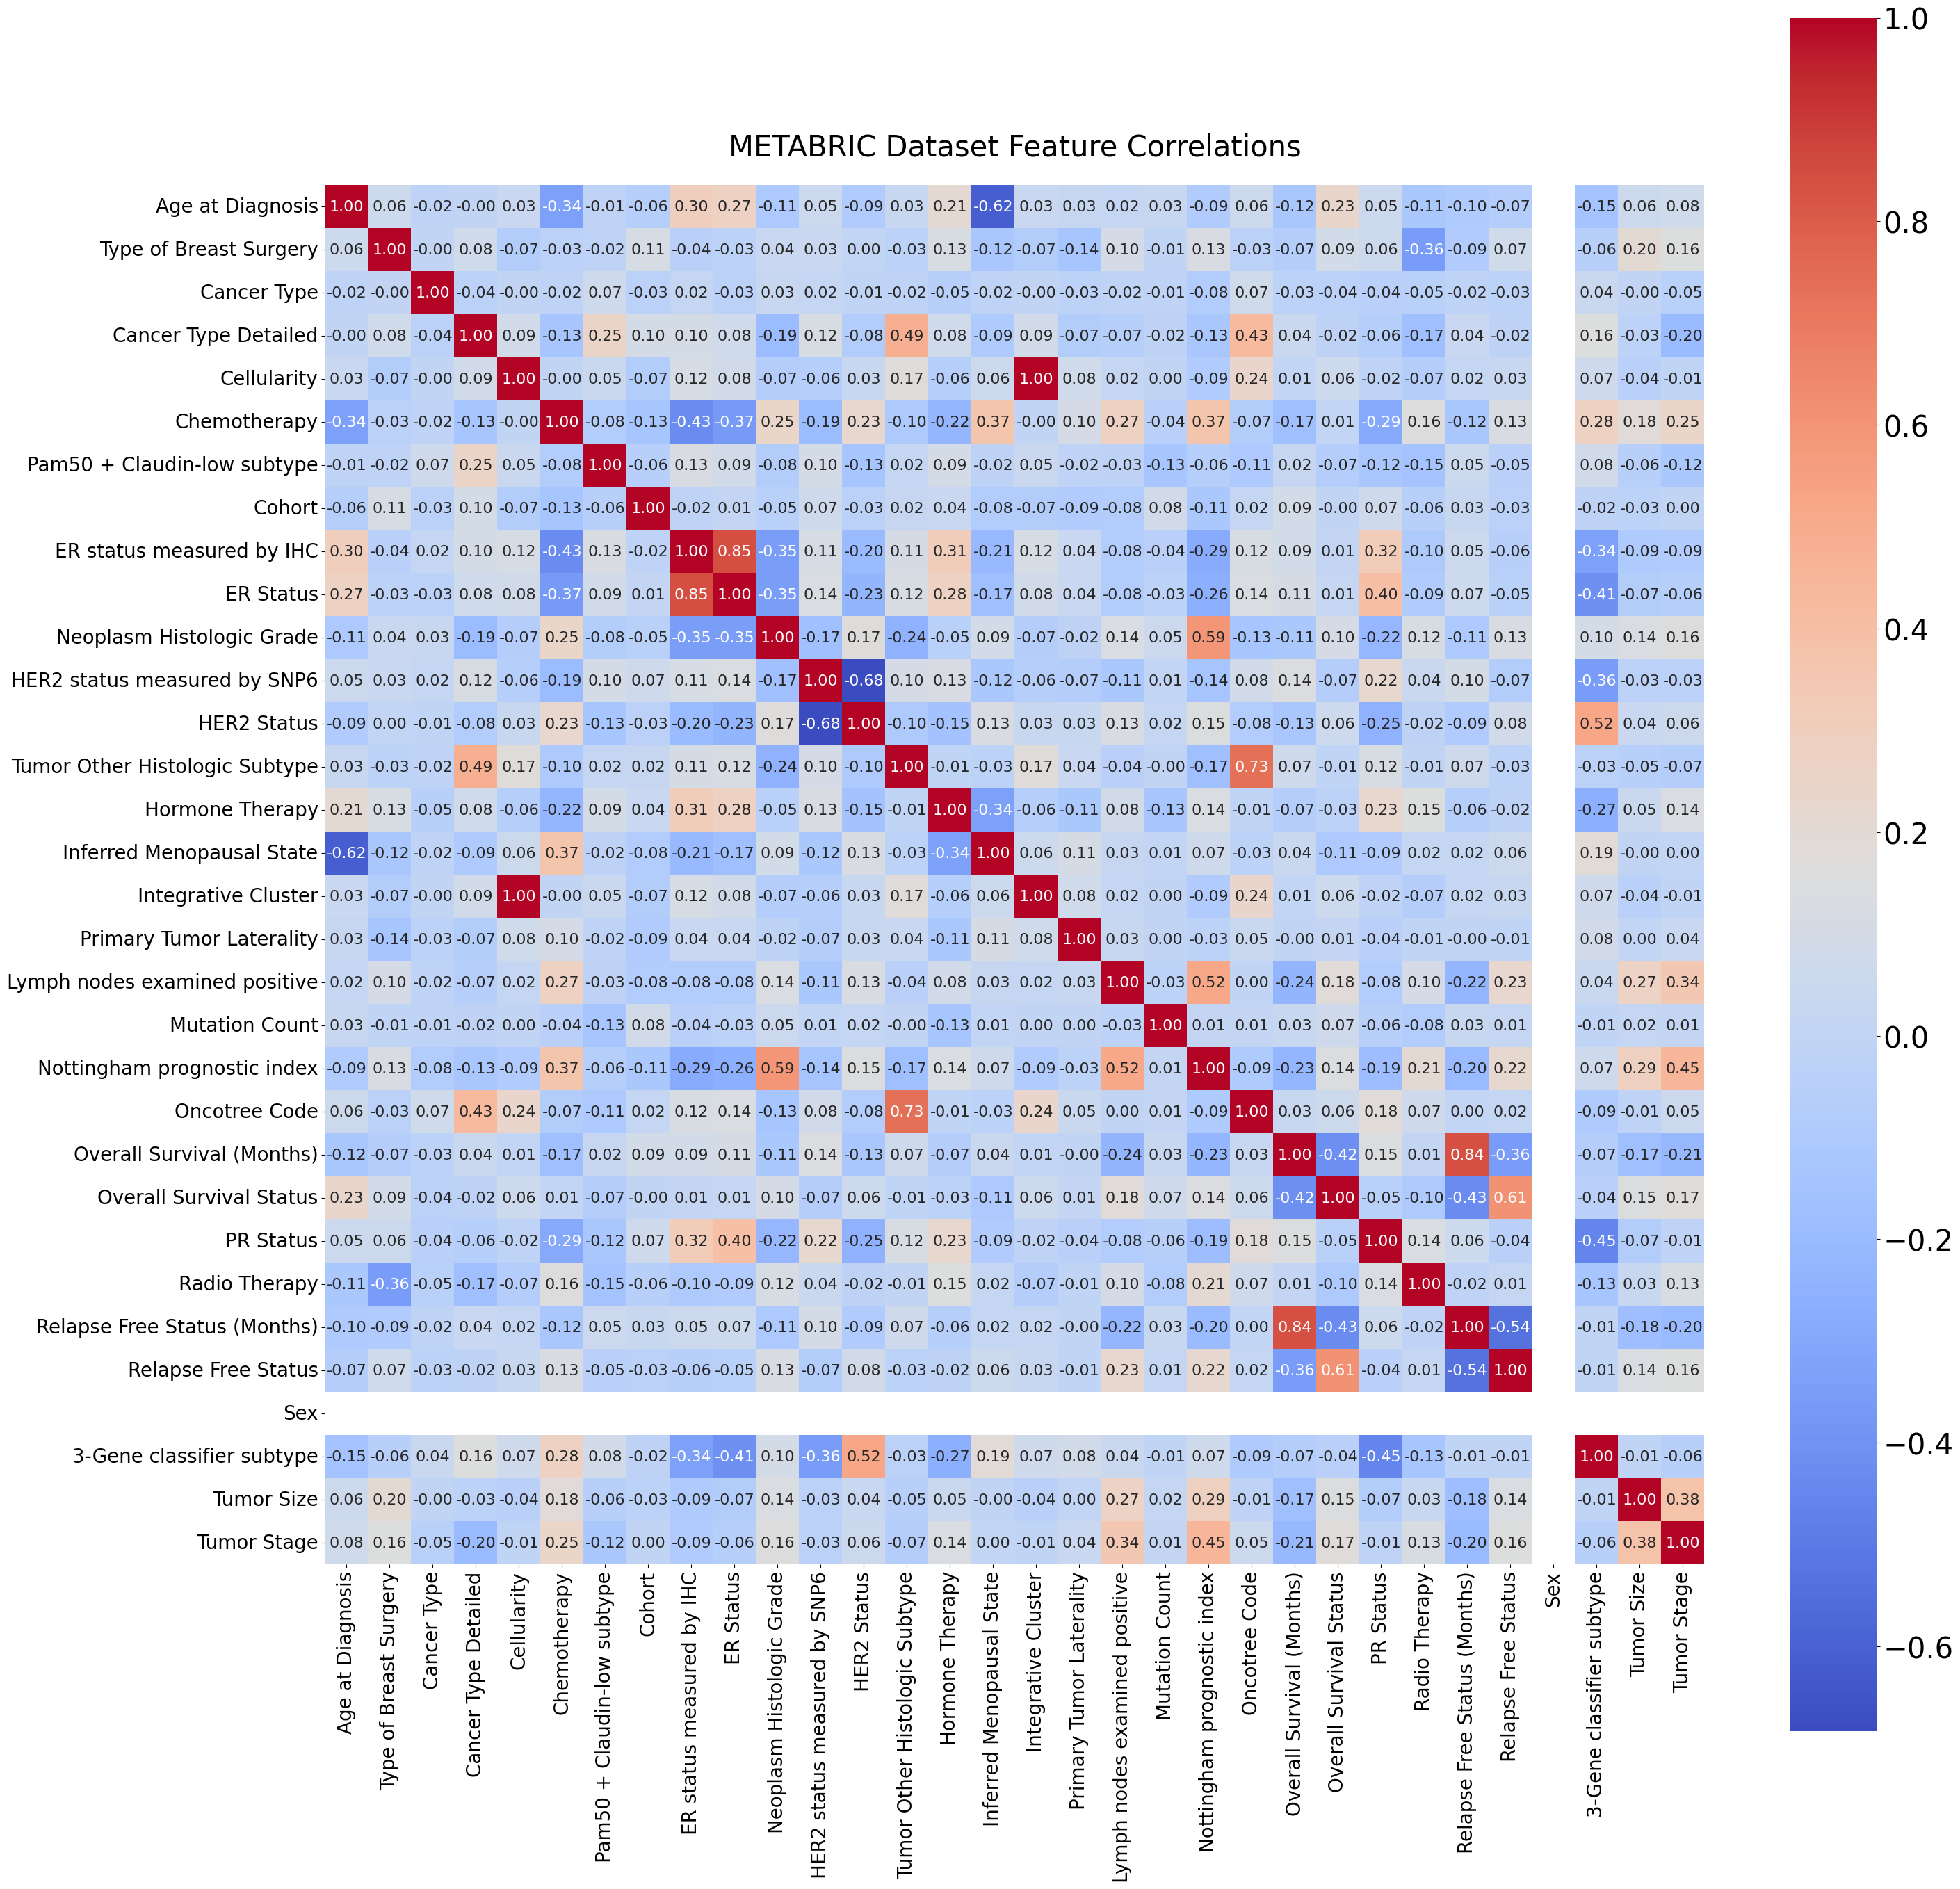

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns for the correlation matrix
df_numeric = df.select_dtypes(include=[np.number])

# Create a large figure for the heatmap
fig = plt.figure(figsize=(32, 32), dpi=100)

# Generate the correlation matrix heatmap
ax = sns.heatmap(df_numeric.corr(), annot=True, square=True, cmap='coolwarm', annot_kws={'size': 16}, fmt='.2f')

# Adjust the color bar size and ticks
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

# Set tick parameters for axis labels and rotation
plt.tick_params(axis='x', labelsize=20, rotation=90)
plt.tick_params(axis='y', labelsize=20, rotation=0)

# Set the title with large font size and padding
plt.title('METABRIC Dataset Feature Correlations', size=30, pad=30)

# Display the plot
plt.show()


In [112]:
df.drop(columns=['Integrative Cluster'], inplace=True)